In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import trange
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score

In [2]:
def display_table(table, row_labels, col_labels):
    html = "<table>"
    html += "<tr><th></th><th>" + "</th><th>".join(col_labels) + "</th></tr>"
    for i, row in enumerate(table):
        html += "<tr><th>" + row_labels[i] + "</th><td>" + "</td><td>".join(map(str, row)) + "</td></tr>"
    html += "</table>"
    display(HTML(html))

def safelog(vals):
    with np.errstate(divide='ignore'):
        return np.log(vals)

def normalize(A):
    # if only one dimension do not transpose
    if len(A.shape) == 1:
        return A / A.sum()
    with np.errstate(divide='ignore'):
        return np.nan_to_num((A.T / A.sum(axis=1)).T)

In [3]:
class BaseRSA:
    def __init__(self, prior, costs, alpha):
        self.prior = prior
        self.costs = costs
        self.alpha = alpha
 
    def L_0(self, A, context=None):
        ''' Literal listener: normalizes the defined lexicon '''
        return normalize(A * self.prior[context])

    def S_p(self, A, context=None):
        ''' Literal speaker: subtract cost from the defined lexicon '''
        return normalize(np.exp(self.alpha * (safelog(self.L_0(A, context).T) + self.costs)))

    def L_p(self, A, context=None):
        ''' Pragmatic listener: normalizes the defined lexicon receiver from the pragmatic speaker '''
        return normalize(self.S_p(A, context).T * self.prior[context])

In [4]:
class Agent(BaseRSA):
    def __init__(self, n_words, n_meanings, prior, costs, alpha):
        BaseRSA.__init__(self, prior, costs, alpha)
        self.lexicons = self.generate_lexicons(n_words, n_meanings)
        self.lexicons_norm = np.array([normalize(lexicon) for lexicon in self.lexicons]) 
        self.lexicon_probs = np.ones(len(self.lexicons)) / len(self.lexicons)

    @staticmethod
    def generate_lexicons(n_words, n_meanings):
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) for i in range(2**(n_words*n_meanings))])
        lexicons = arrays.reshape((2**(n_words*n_meanings), n_words, n_meanings))
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

    def speaker(self, meaning, context):
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        return self.S_p(lexicon, context)[meaning].argmax()
    
    def listener(self, message, context):
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        return self.L_p(lexicon, context)[message].argmax()
    
    def update_lexicon(self, message, meaning):
        self.lexicon_probs = normalize(self.lexicon_probs * self.lexicons_norm[:, message, meaning] + 1e-5)

In [5]:
N_MEANINGS = 3
PRIOR = np.array([[1, 1, 0], [1, 0, 1]]) # should we normalize?
COSTS = np.array([0, 40])
ALPHA = 5
context_meanings = {0: [0, 1], 1: [0], 2: [1]}
# 0 -- star 
# 1 -- circle
# 2 -- triangle

posts = []
logs_comp = []

for tr in trange(100):
    agent1 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    agent2 = Agent(n_words = 2, n_meanings = N_MEANINGS, prior = PRIOR, costs = COSTS, alpha = ALPHA)
    logs = defaultdict(dict)
    for _ in range(100):
        meaning = np.random.randint(0, N_MEANINGS)
        context = np.random.choice(context_meanings[meaning])
        logs[_] = {'trial': tr, 'context': context, 'meaning': meaning}
        if _ % 2 == 0:
            message = agent1.speaker(meaning, context)
            meaning_guess = agent2.listener(message, context)
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
        else:
            message = agent2.speaker(meaning, context)
            meaning_guess = agent1.listener(message, context)  
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
    logs_comp.append(logs)
    posts.append(agent1.lexicon_probs)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_40382/1724682641.py:18: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)


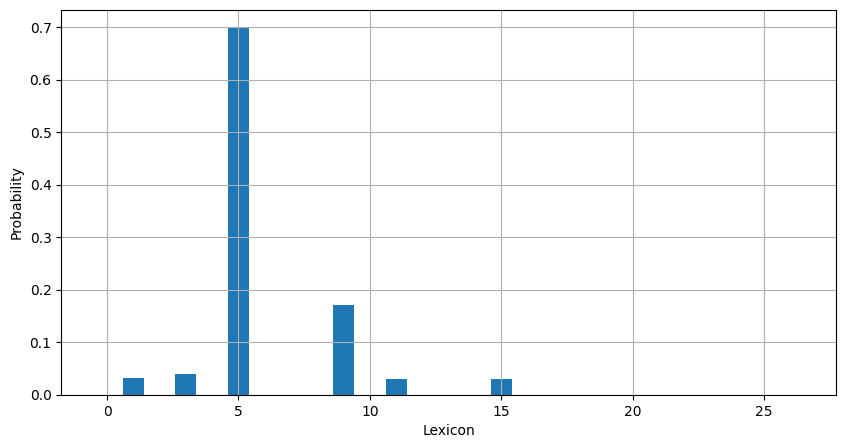

In [6]:
# sum over posts
lexicon_probs = np.sum(posts, axis=0)
# normalize
lexicon_probs = lexicon_probs / lexicon_probs.sum()

# plot the posterior distribution of the lexicons
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(lexicon_probs)), lexicon_probs)
plt.xlabel('Lexicon')
plt.ylabel('Probability')
plt.grid()

In [7]:
logs[1]

{'trial': 99,
 'context': 1,
 'meaning': 2,
 'message': 1,
 'meaning_guess': 0,
 'correct': False}

In [8]:
#### NB: removing first 20 trials ####
logs_comb = pd.concat([pd.DataFrame(k).T.reset_index() for k in logs_comp]).reset_index(drop=True)

In [9]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')

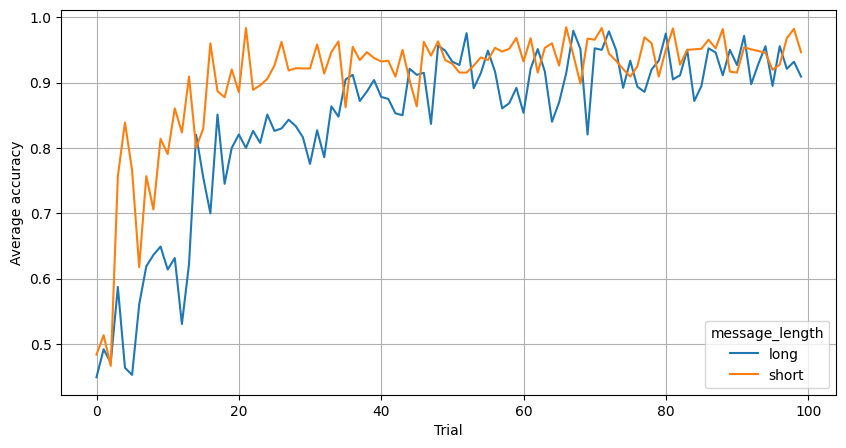

In [10]:
# group by index and plot average accuracy per index and per word
logs_comb.groupby(['index', 'message_length']).correct.mean().unstack().plot(figsize=(10, 5))
plt.xlabel('Trial')
plt.ylabel('Average accuracy')
plt.grid()

<AxesSubplot: xlabel='meaning_s', ylabel='Count'>

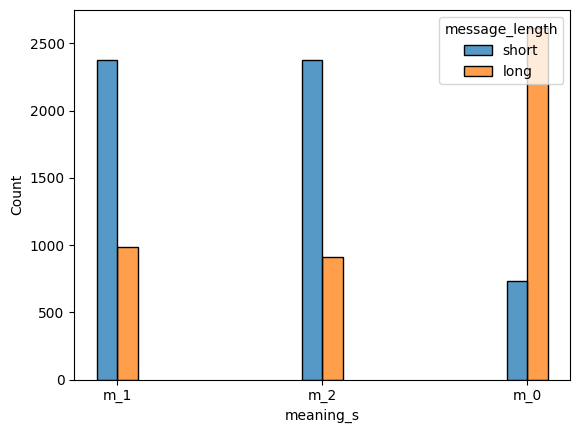

In [11]:
# plot histogram of meanings and how often short of long messages are used, order x axis by name
sns.histplot(data=logs_comb, x='meaning_s', hue='message_length', multiple='dodge', shrink=.2)

In [12]:
dfs = [pd.DataFrame(k).T for k in logs_comp]

In [13]:
results = defaultdict(dict)

for i, df in enumerate(dfs):
    ll_ = normalized_mutual_info_score(df['meaning'], df['meaning_guess'])
    # count percentage of long word being used with meaning 0
    long_0 = df[(df['meaning'] == 0) & (df['message'] == 1)].shape[0] / df[df['meaning'] == 0].shape[0]
    # compute percentage of short word being used with meaning 1 and 2
    long_1 = df[(df['meaning'] != 0) & (df['message'] == 0)].shape[0] / df[df['meaning'] != 0].shape[0]
    # assign numerical_length to 0 as 1 and 1 as 10
    df['numerical_length'] = df['message'].apply(lambda x: 1 if x == 0 else 10)
    # write it down to results
    results[i]['cross_entropy'] = ll_
    results[i]['long_0'] = long_0
    results[i]['short_1'] = long_1
    results[i]['avg_length'] = df['numerical_length'].mean()


In [14]:
# convert results to dataframe
results = pd.DataFrame(results).T

In [15]:
results.columns = ['cross_entropy', 'long_0', 'short_1', 'avg_length']

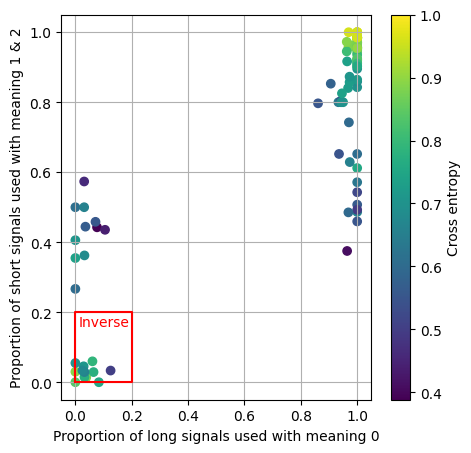

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(results['long_0'], results['short_1'], c=results['cross_entropy'])
plt.xlabel('Proportion of long signals used with meaning 0')
plt.ylabel('Proportion of short signals used with meaning 1 & 2')
plt.grid()
# add label to colorbar saying cross entropy
plt.colorbar().set_label('Cross entropy')
# add a text to 0.2, 0.2 saying inverse in red
plt.text(0.012, 0.16, 'Inverse', color='red')
# add a square around points on 0., 0.0
plt.plot([0.0, 0.0, 0.2, 0.2, 0.0], [0.0, 0.2, 0.2, 0.0, 0.0], color='red')


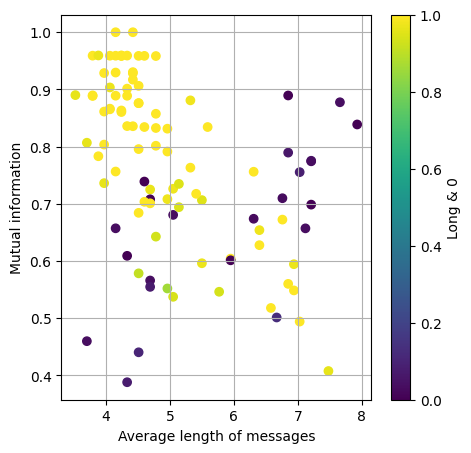

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(results['avg_length'], results['cross_entropy'], c=results['long_0'])
plt.xlabel('Average length of messages')
plt.ylabel('Mutual information')
plt.colorbar().set_label('Long & 0')
plt.grid()

Text(33.22222222222222, 0.5, 'Message length')

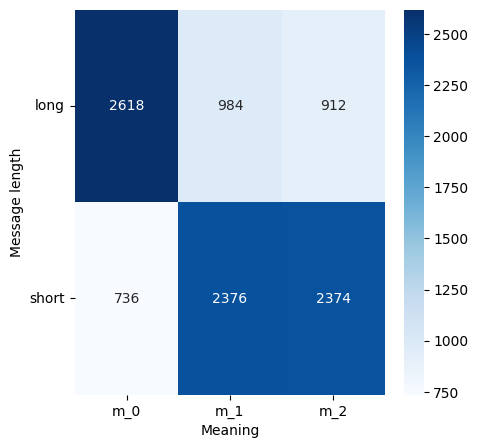

In [18]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')
plt.figure(figsize=(5, 5))
sns.heatmap(pd.crosstab(logs_comb['message_length'], logs_comb['meaning_s']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel('Meaning')
plt.ylabel('Message length')